<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/Finding and Correcting Mistakes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/Finding and Correcting Mistakes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/Finding and Correcting Mistakes.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/Finding and Correcting Mistakes.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# <span style="color: orange">**Finding and Correcting Mistakes with FiftyOne**

<img src="/home/dan/Downloads/Logo_FullVoxel51_White.png" alt="Logo" width="1071" height="293" />


## Find and Removing Duplicates

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the CIFAR-10 test split
# Downloads the dataset from the web if necessary
dataset = foz.load_zoo_dataset("cifar10", split="test")

/home/dan/.local/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Split 'test' already downloaded
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [2.9s elapsed, 0s remaining, 3.4K samples/s]      
Dataset 'cifar10-test' created


/home/dan/.local/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



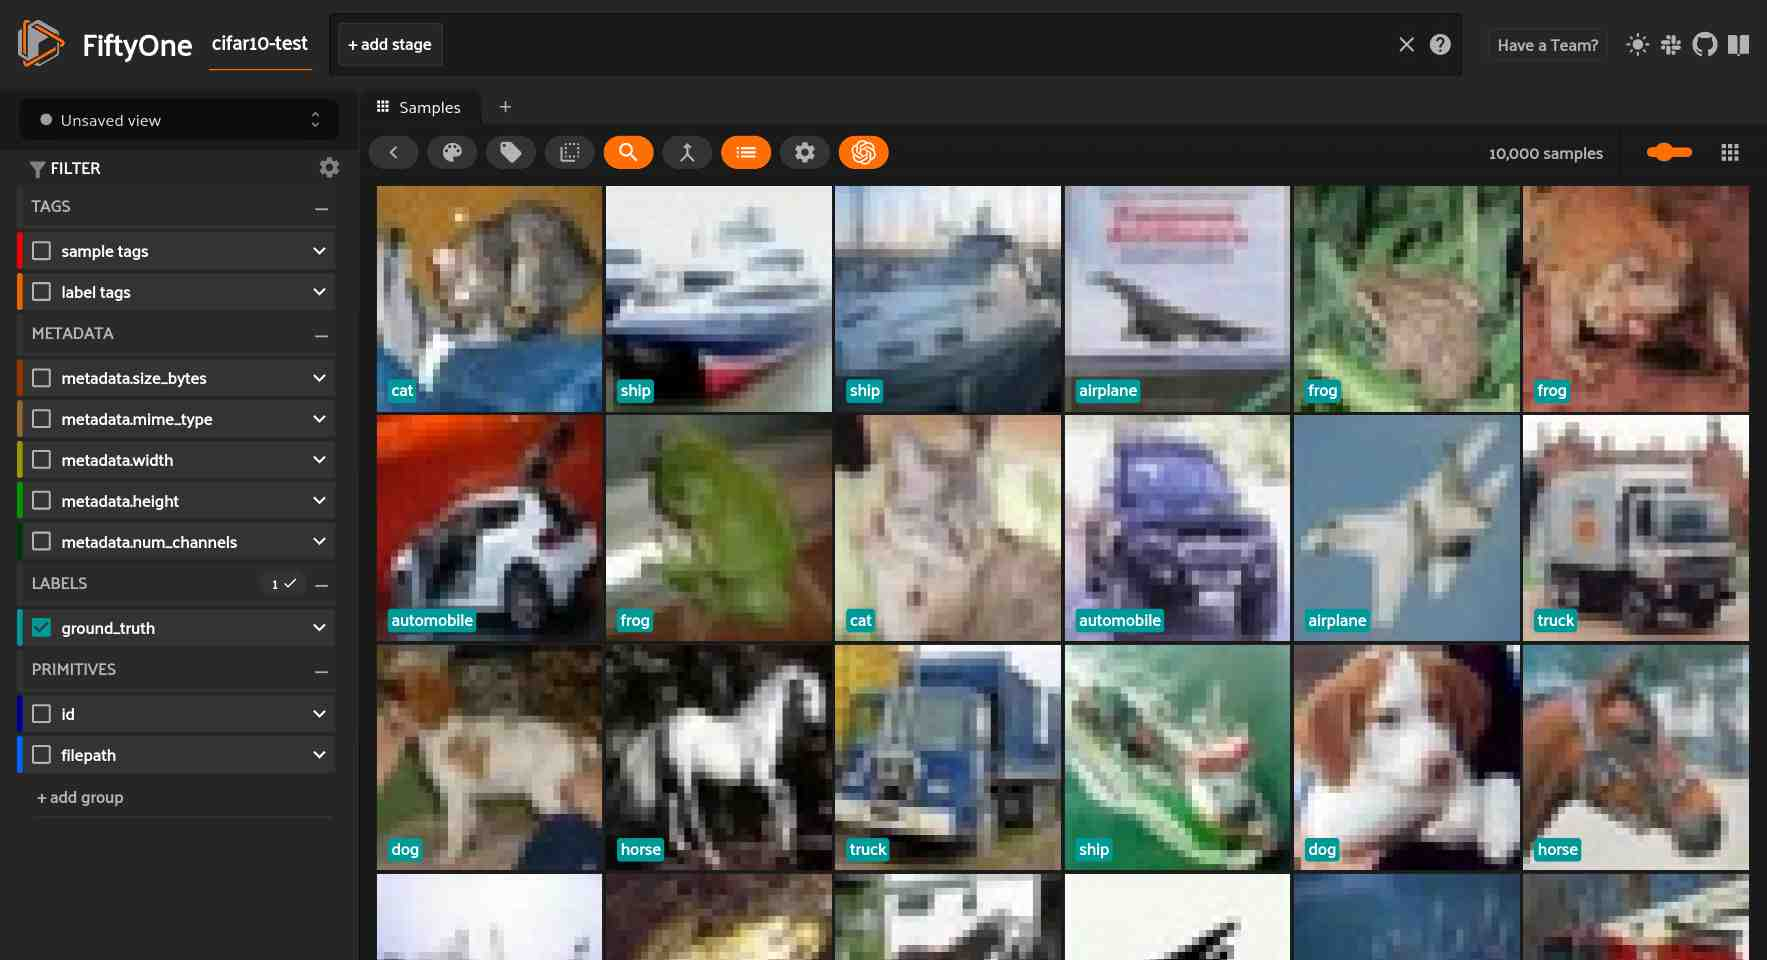

In [2]:
session = fo.launch_app(dataset)

In [3]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

Computing embeddings...
   0% ||------------|    16/10000 [3.1s elapsed, 32.6m remaining, 5.1 samples/s] 

/home/dan/Documents/fiftyone/fiftyone/utils/torch.py:695: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/dan/Documents/fiftyone/fiftyone/utils/torch.py:696: RuntimeWarning: invalid value encountered in true_divide
  odds /= np.sum(odds, axis=1, keepdims=True)


 100% |█████████████| 10000/10000 [5.7s elapsed, 0s remaining, 4.3K samples/s]      
Computing uniqueness...
Uniqueness computation complete



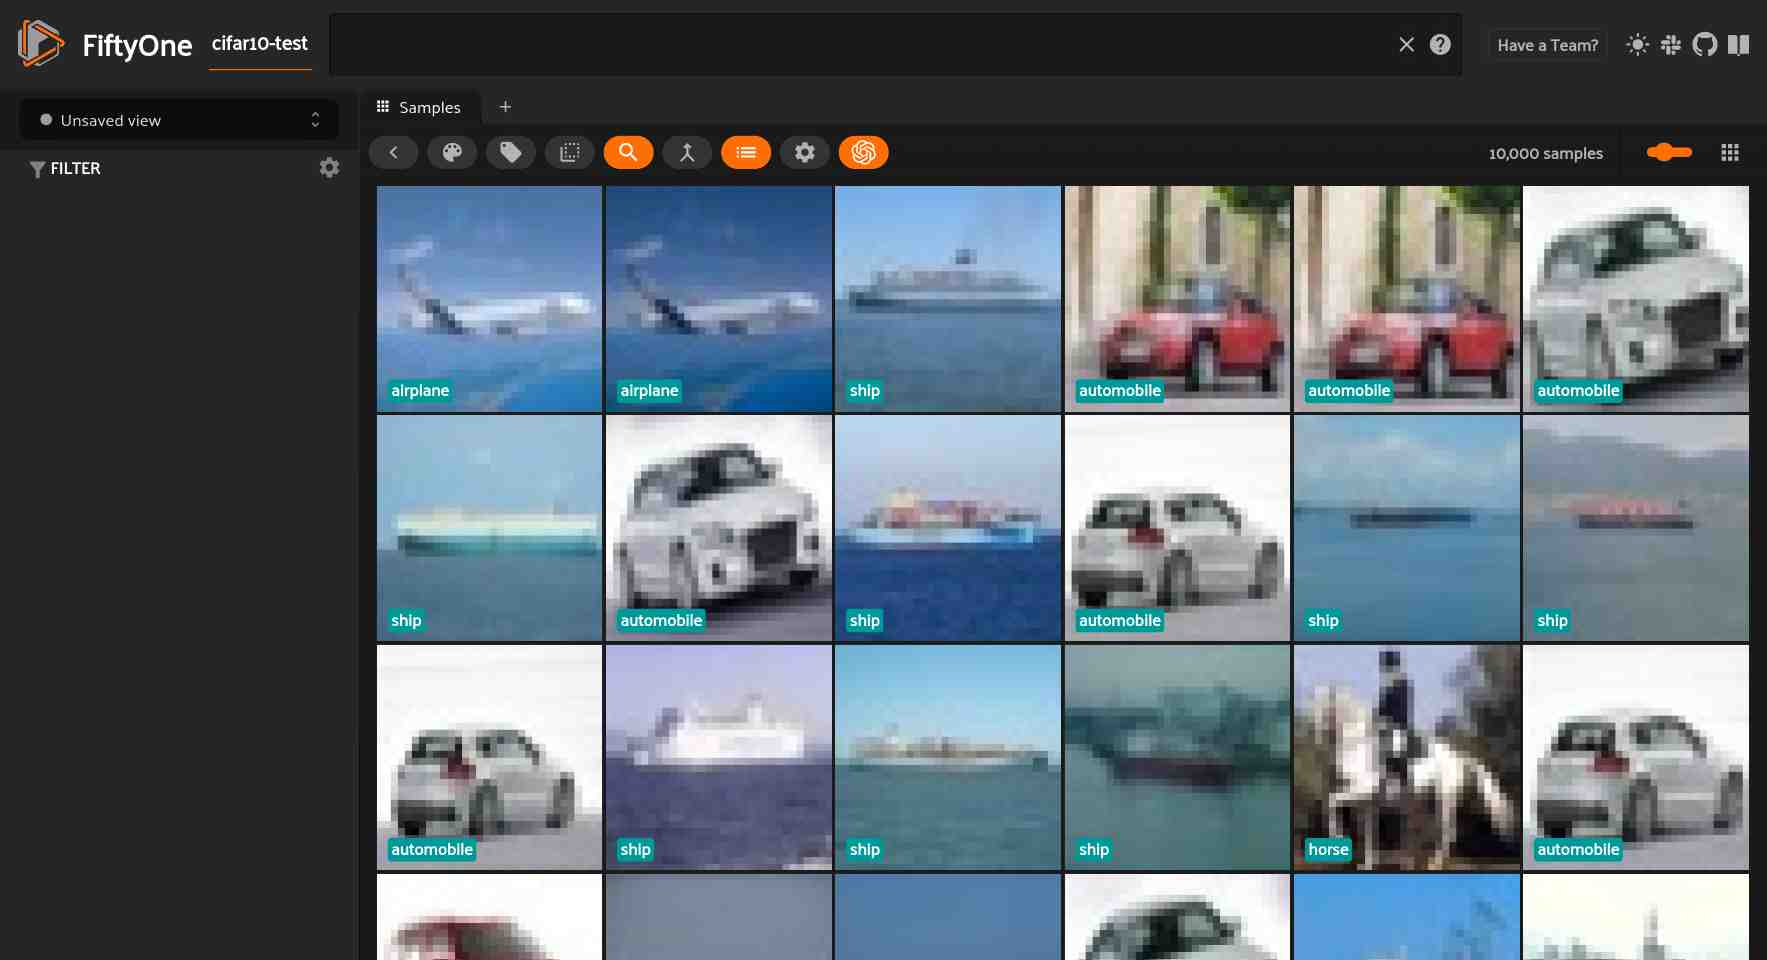

In [4]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view


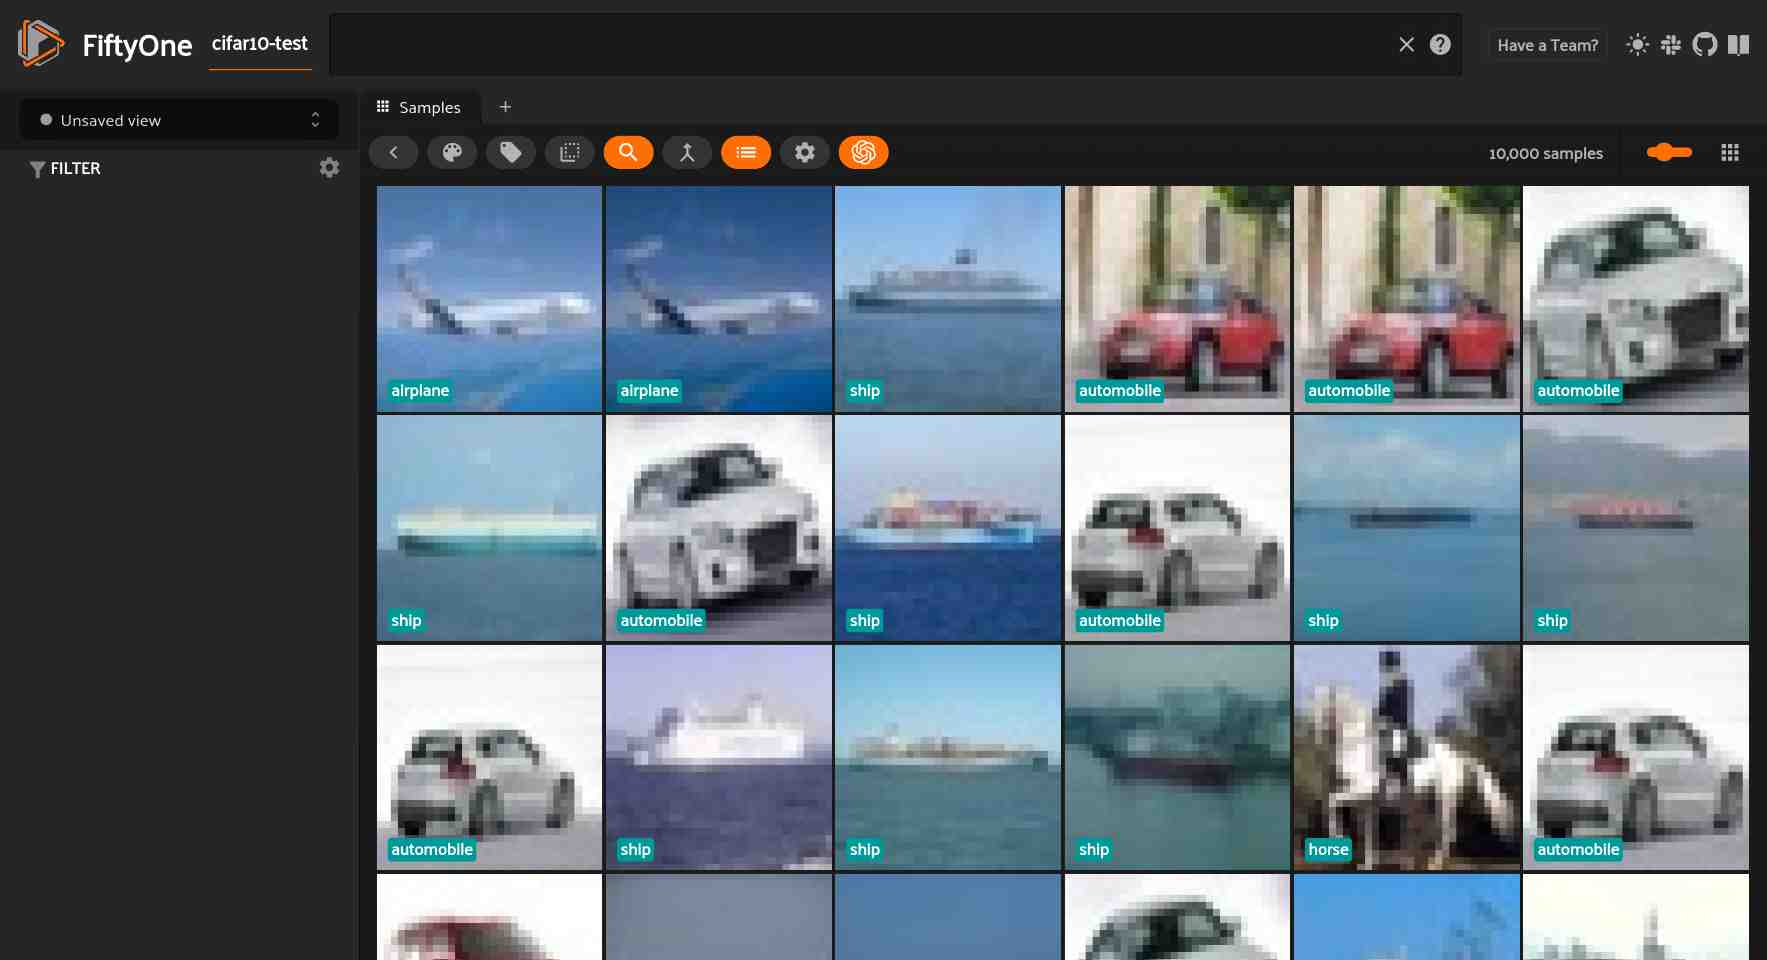

In [5]:
# Get currently selected images from App
dup_ids = session.selected

# Mark as duplicates
dups_view = dataset.select(dup_ids)
dups_view.tag_samples("dups")

# Visualize duplicates-only in App
session.view = dups_view


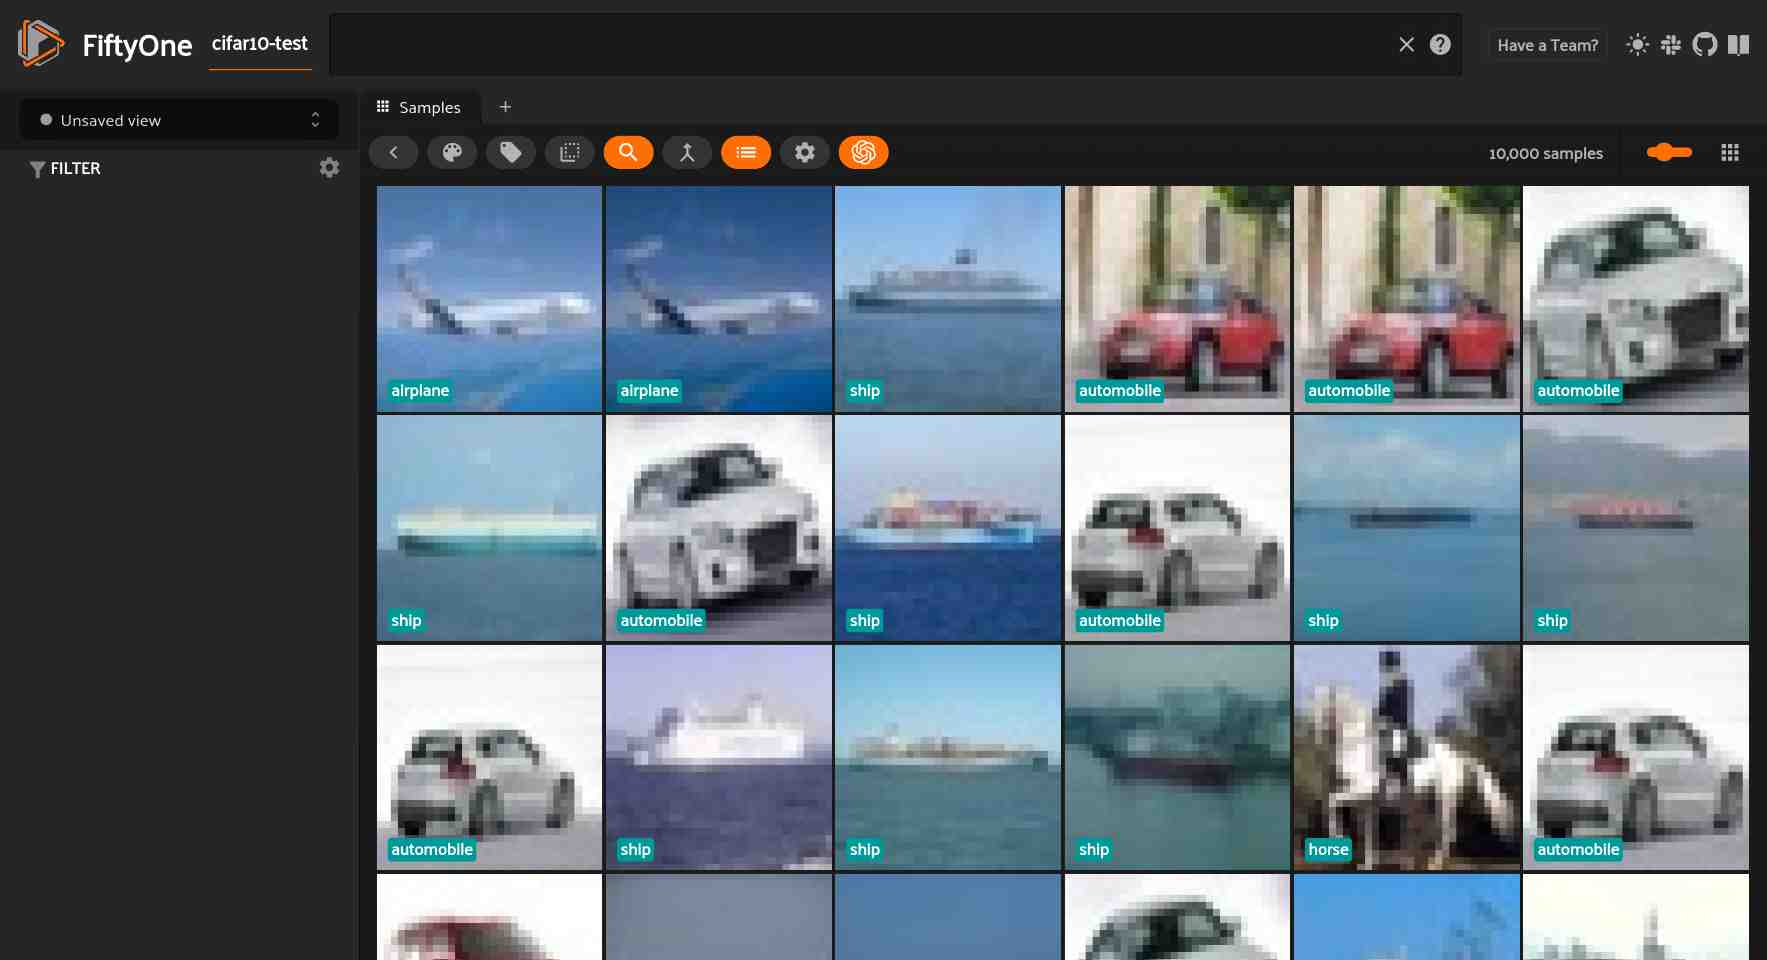

In [6]:
from fiftyone import ViewField as F
clean_view = dataset.sort_by("uniqueness").match_tags("dups", bool=False)

# Open view in the App
session.view = clean_view



In [ ]:
import fiftyone as fo

export_dir = "/path/for/image-classification-dir-tree"
label_field = "ground_truth"  # for example

# Export the dataset
clean_view.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field=label_field,
)

## Finding Classification Mistakes

In [13]:
# Download the software
!git clone --depth 1 --branch v2.1 https://github.com/huyvnphan/PyTorch_CIFAR10.git

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 82 (delta 13), reused 60 (delta 12), pack-reused 0
Receiving objects: 100% (82/82), 5.16 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Note: switching to '2a2e76a56f943b70403796387d968704e74971ae'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/home/dan/.local/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A Nu

In [8]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.append("./PyTorch_CIFAR10")
from cifar10_models import resnet50

import random

import fiftyone as fo
import fiftyone.zoo as foz

# Load the CIFAR-10 test split
# Downloads the dataset from the web if necessary
dataset = foz.load_zoo_dataset("cifar10", split="test")

# Get the CIFAR-10 classes list
classes = dataset.default_classes

# Artificially corrupt 10% of the labels
_num_mistakes = int(0.1 * len(dataset))
for sample in dataset.take(_num_mistakes):
    mistake = random.randint(0, 9)
    while classes[mistake] == sample.ground_truth.label:
        mistake = random.randint(0, 9)

    sample.tags.append("mistake")
    sample.ground_truth = fo.Classification(label=classes[mistake])
    sample.save()
    

def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences, logits


#
# Load a model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)
model_name = "resnet50"

#
# Extract a few images to process
# (some of these will have been manipulated above)
#

num_samples = 1000
batch_size = 20
view = dataset.take(num_samples)
image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view.iter_samples()])
data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

with fo.ProgressBar() as pb:
    for imgs, sample_ids in pb(data_loader):
        predictions, _, logits_ = predict(model, imgs)

        # Add predictions to your FiftyOne dataset
        for sample_id, prediction, logits in zip(sample_ids, predictions, logits_):
            sample = dataset[sample_id]
            sample.tags.append("processed")
            sample[model_name] = fo.Classification(
                label=classes[prediction], logits=logits,
            )
            sample.save()

Split 'test' already downloaded
Loading existing dataset 'cifar10-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
 100% |███████████████████| 50/50 [5.2s elapsed, 0s remaining, 10.3 samples/s]      


In [9]:
# Count the number of samples with the `processed` tag
num_processed = len(dataset.match_tags("processed"))

# Count the number of samples with both `processed` and `mistake` tags
num_corrupted = len(dataset.match_tags("processed").match_tags("mistake"))

print("Added predictions to %d samples" % num_processed)
print("%d of these samples have label mistakes" % num_corrupted)

Added predictions to 1900 samples
366 of these samples have label mistakes


In [10]:
import fiftyone.brain as fob

# Get samples for which we added predictions
h_view = dataset.match_tags("processed")

# Compute mistakenness
fob.compute_mistakenness(h_view, model_name, label_field="ground_truth", use_logits=True)

Computing mistakenness...
 100% |███████████████| 1900/1900 [2.5s elapsed, 0s remaining, 833.6 samples/s]      
Mistakenness computation complete



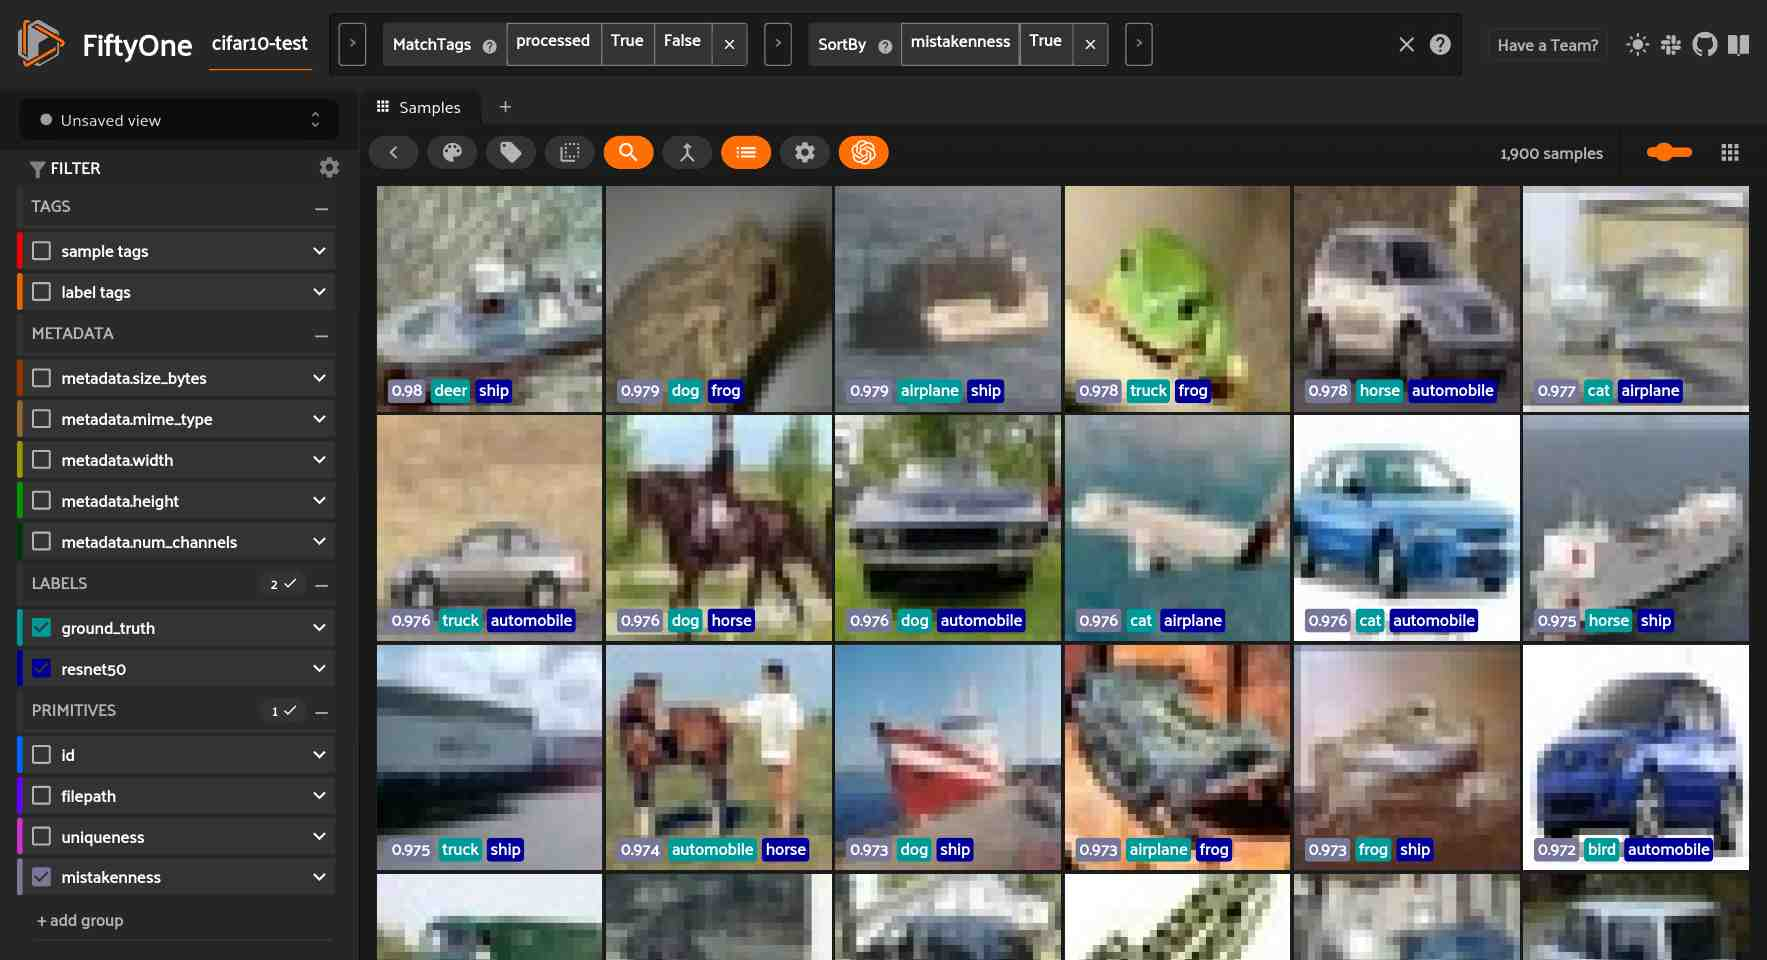

In [11]:
# Sort by likelihood of mistake (most likely first)
mistake_view = (dataset
    .match_tags("processed")
    .sort_by("mistakenness", reverse=True)
)
# Show only the samples for which we added label mistakes
session.view = mistake_view

## Find and Correcting Detection Mistakes

In [7]:
dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=1000, overwrite=True, dataset_name="Find Mistakes")

Overwriting existing directory '/home/dan/fiftyone/coco-2017/validation'
Found annotations at '/home/dan/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |████████████████| 1000/1000 [13.0s elapsed, 0s remaining, 61.9 images/s]      
Writing annotations for 1000 downloaded samples to '/home/dan/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/home/dan/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 1000/1000 [3.2s elapsed, 0s remaining, 316.4 samples/s]      
Dataset 'Find Mistakes' created


In [8]:
import fiftyone.utils.iou as foui

foui.compute_max_ious(dataset, "ground_truth", iou_attr="max_iou", classwise=True)
print("Max IoU range: (%f, %f)" % dataset.bounds("ground_truth.detections.max_iou"))

 100% |███████████████| 1000/1000 [1.5s elapsed, 0s remaining, 694.9 samples/s]         
Max IoU range: (0.000000, 0.951640)


In [10]:
# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels("ground_truth", F("max_iou") > 0.75)
print(dups_view)

Dataset:     Find Mistakes
Media type:  image
Num samples: 7
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$gt': ['$$this.max_iou', 0.75]}, only_matches=True, trajectories=False)



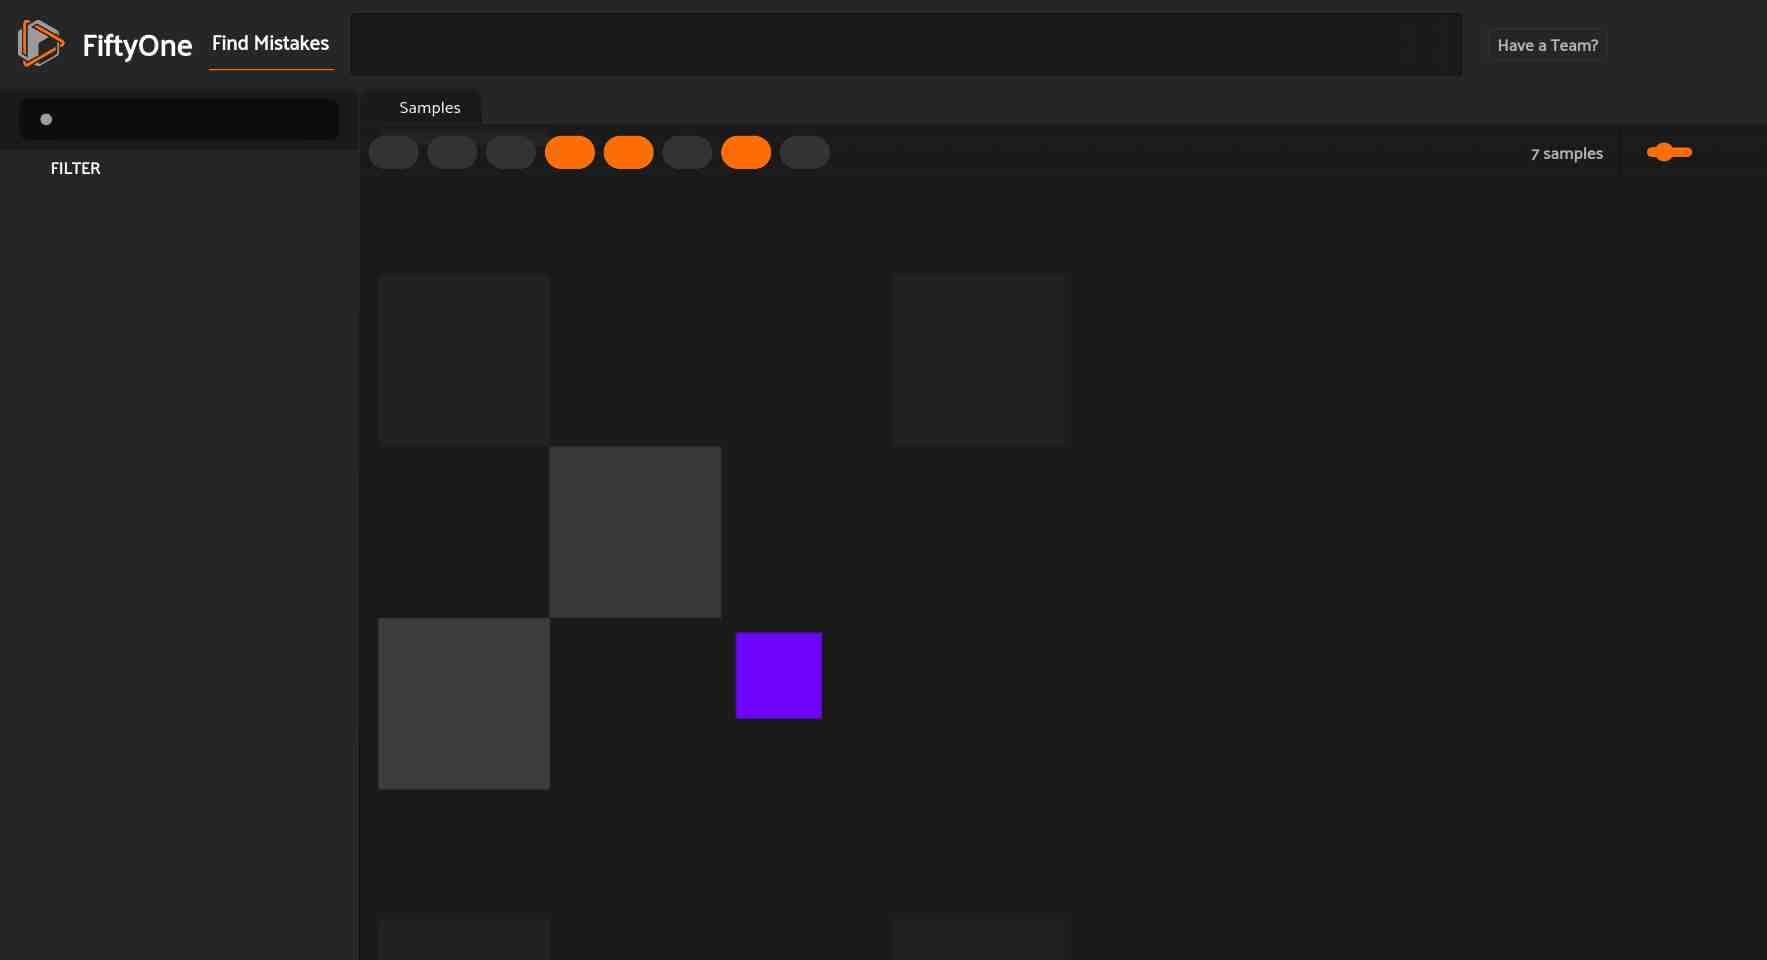

In [11]:
session.view = dups_view

In [12]:
dataset.delete_labels(tags="dups")

In [13]:
# Verify that tagged labels were deleted
print(dataset.count_label_tags())

{}



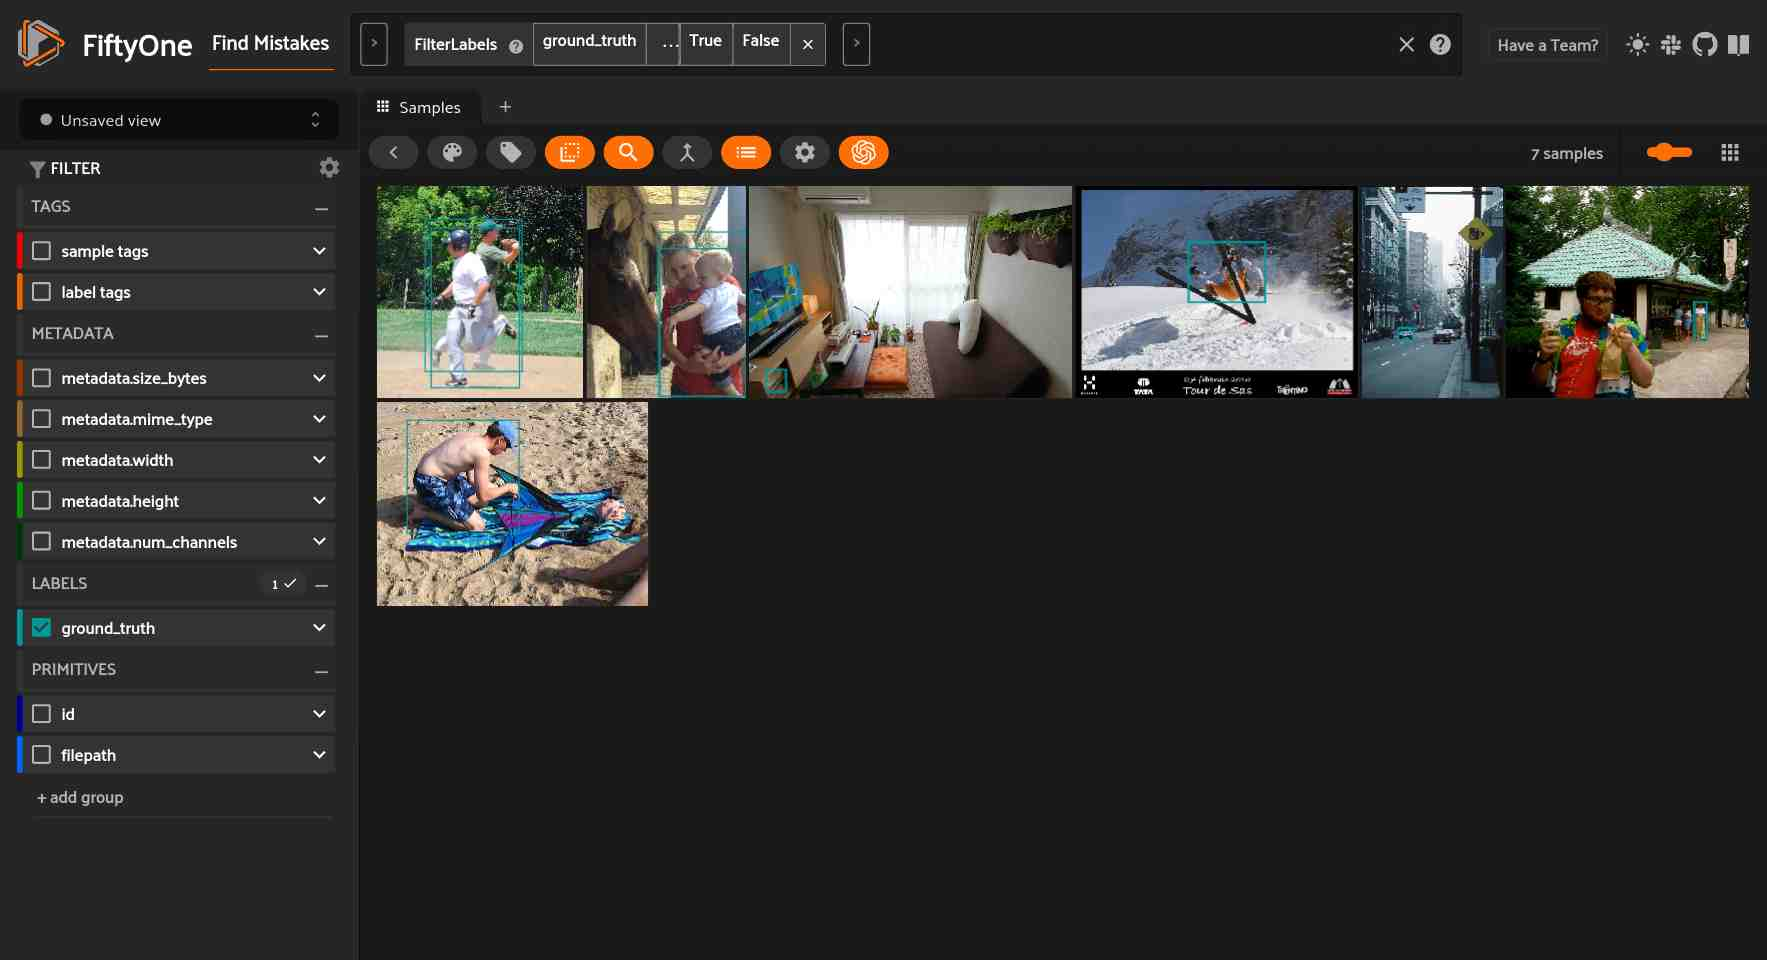

In [14]:
session.view = dups_view

In [15]:
dup_ids = foui.find_duplicates(
    dataset, "ground_truth", iou_thresh=0.75, classwise=True
)
print("Found %d duplicates" % len(dup_ids))

   0% ||--------------|    0/1000 [15.5ms elapsed, ? remaining, ? samples/s] 

 100% |███████████████| 1000/1000 [1.6s elapsed, 0s remaining, 646.2 samples/s]         
Found 6 duplicates


In [16]:
# Cleanup any previous tags (if necessary)
dataset.untag_labels("dups")

In [17]:
# Tag the automatically selected duplicates
dataset.select_labels(ids=dup_ids).tag_labels("duplicate")

In [18]:
session.view = dataset.match_labels(ids=dup_ids)

In [ ]:
anno_key = "remove_dups"
dups_view.annotate(anno_key, label_field="ground_truth", launch_editor=True)

In [ ]:
dataset.load_annotations(anno_key)